In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer as mlb
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [2]:
data = pd.read_csv("../latestdata.csv")

needed_column = [
    "age",
    "sex",
    "city",
    "province",
    "country",
    "latitude",
    "longitude",
    "symptoms",
    "date_confirmation",
    "chronic_disease_binary",
]
df = data[needed_column]

C:\Users\User\AppData\Local\Temp\ipykernel_19896\1236254982.py:1: DtypeWarning: Columns (1,2,9,10,12,13,14,15,16,17,19,20,21,22,23,24,25,26,27,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../latestdata.csv")


In [3]:
print(df)

          age     sex            city          province    country   latitude  \
0         NaN    male        Shek Lei         Hong Kong      China  22.365019   
1          78    male      Vo Euganeo            Veneto      Italy  45.297748   
2          61  female             NaN               NaN  Singapore   1.353460   
3         NaN     NaN  Zhengzhou City             Henan      China  34.629310   
4         NaN     NaN  Pingxiang City           Jiangxi      China  27.513560   
...       ...     ...             ...               ...        ...        ...   
2676306  52.0  female        Calleria  Coronel Portillo       Peru  -8.378190   
2676307  52.0  female    Pueblo Libre              Lima       Peru -12.076530   
2676308  52.0  female           Comas              Lima       Peru -11.932980   
2676309  52.0    male          Callao            Callao       Peru -12.000740   
2676310  52.0    male      Los Olivos              Lima       Peru -11.976260   

          longitude symptom

In [4]:
# Remove Symptoms Missing Information
df = df.dropna(subset=['symptoms'])
print("\nNull Value count")
for col in df:
    print("{} = {}".format(col, df[col].isnull().sum()))


Null Value count
age = 475
sex = 456
city = 734
province = 108
country = 30
latitude = 0
longitude = 0
symptoms = 0
date_confirmation = 38
chronic_disease_binary = 0


In [6]:
# Remove Special Expression
df['symptoms'] = df['symptoms'].str.replace("Â", "").str.replace("°C", "").str.replace("°F", "").str.strip()

In [8]:
# Remove Missing Rows in other variables

df = df.dropna()
print("\nNull Value count")
for col in df:
    print("{} = {}".format(col, df[col].isnull().sum()))


Null Value count
age = 0
sex = 0
city = 0
province = 0
country = 0
latitude = 0
longitude = 0
symptoms = 0
date_confirmation = 0
chronic_disease_binary = 0


In [9]:
print(df)

          age     sex              city             province        country  \
476        60    male          Yokohama  Kanagawa Prefecture          Japan   
756     20-29    male    Haneda Airport                Tokyo          Japan   
777     50-59    male         Yuasa-cho  Wakayama Prefecture          Japan   
778     50-59  female         Yuasa-cho  Wakayama Prefecture          Japan   
781     60-69    male         Yuasa-cho  Wakayama Prefecture          Japan   
...       ...     ...               ...                  ...            ...   
658595  50-59  female              Ajax              Ontario         Canada   
658596  60-69    male              Ajax              Ontario         Canada   
672418     35    male  Snohomish County           Washington  United States   
672428  60-69    male           Toronto              Ontario         Canada   
674650     39  female     New York City             New York  United States   

         latitude   longitude                   sym

### EDA

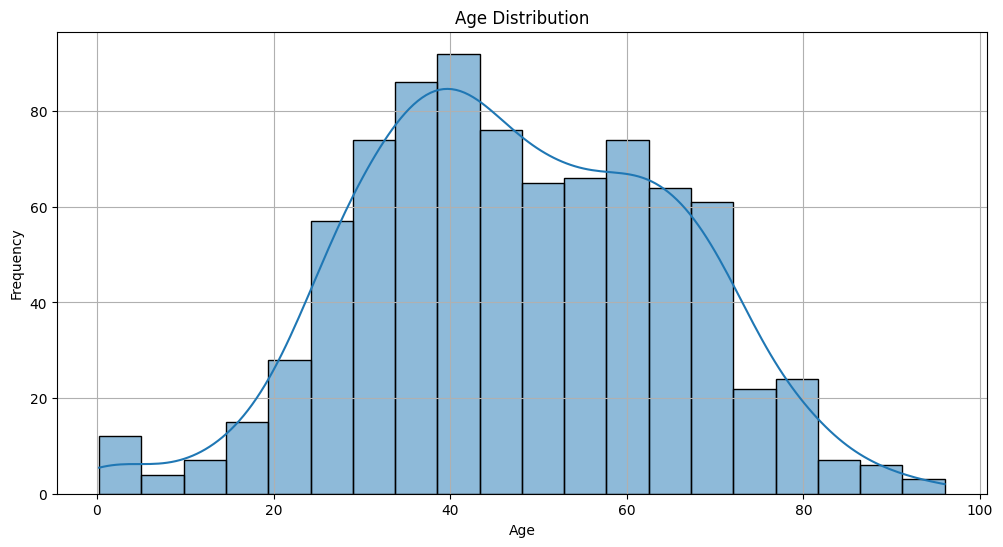

In [29]:
# Age

df['age'] = pd.to_numeric(df['age'], errors='coerce')

plt.figure(figsize=(12, 6))
sns.histplot(df['age'], bins=20, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid()
plt.show()

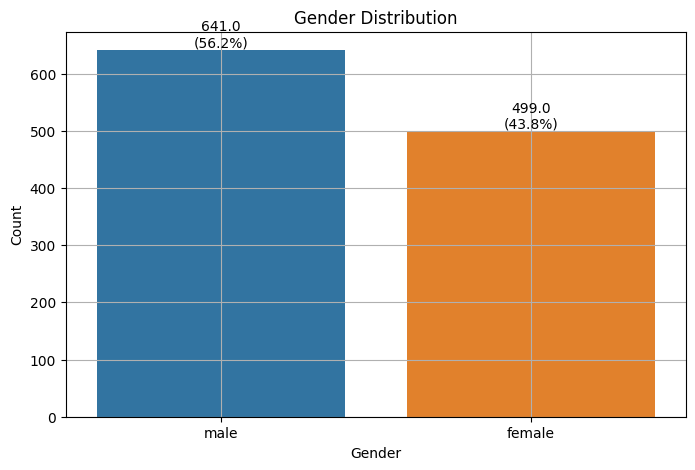

In [33]:
# Gender

plt.figure(figsize=(8, 5))
gender_counts = df['sex'].value_counts()
sns.countplot(x='sex', data=df)

total_counts = gender_counts.sum()
percentages = (gender_counts / total_counts) * 100

for i, p in enumerate(plt.gca().patches):
    plt.annotate(f'{p.get_height()}\n({percentages[i]:.1f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.grid()
plt.show()

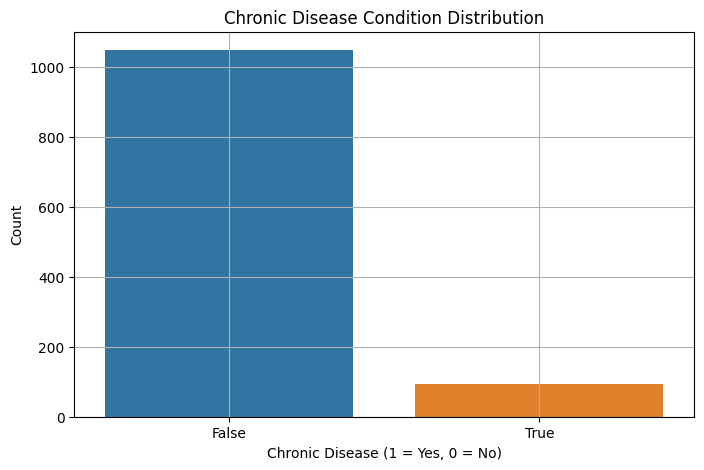

In [34]:
# Chronic Disease Condition Distribution

plt.figure(figsize=(8, 5))
sns.countplot(x='chronic_disease_binary', data=df)
plt.title('Chronic Disease Condition Distribution')
plt.xlabel('Chronic Disease (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.grid()
plt.show()

C:\Users\User\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65374 (\N{FULLWIDTH TILDE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


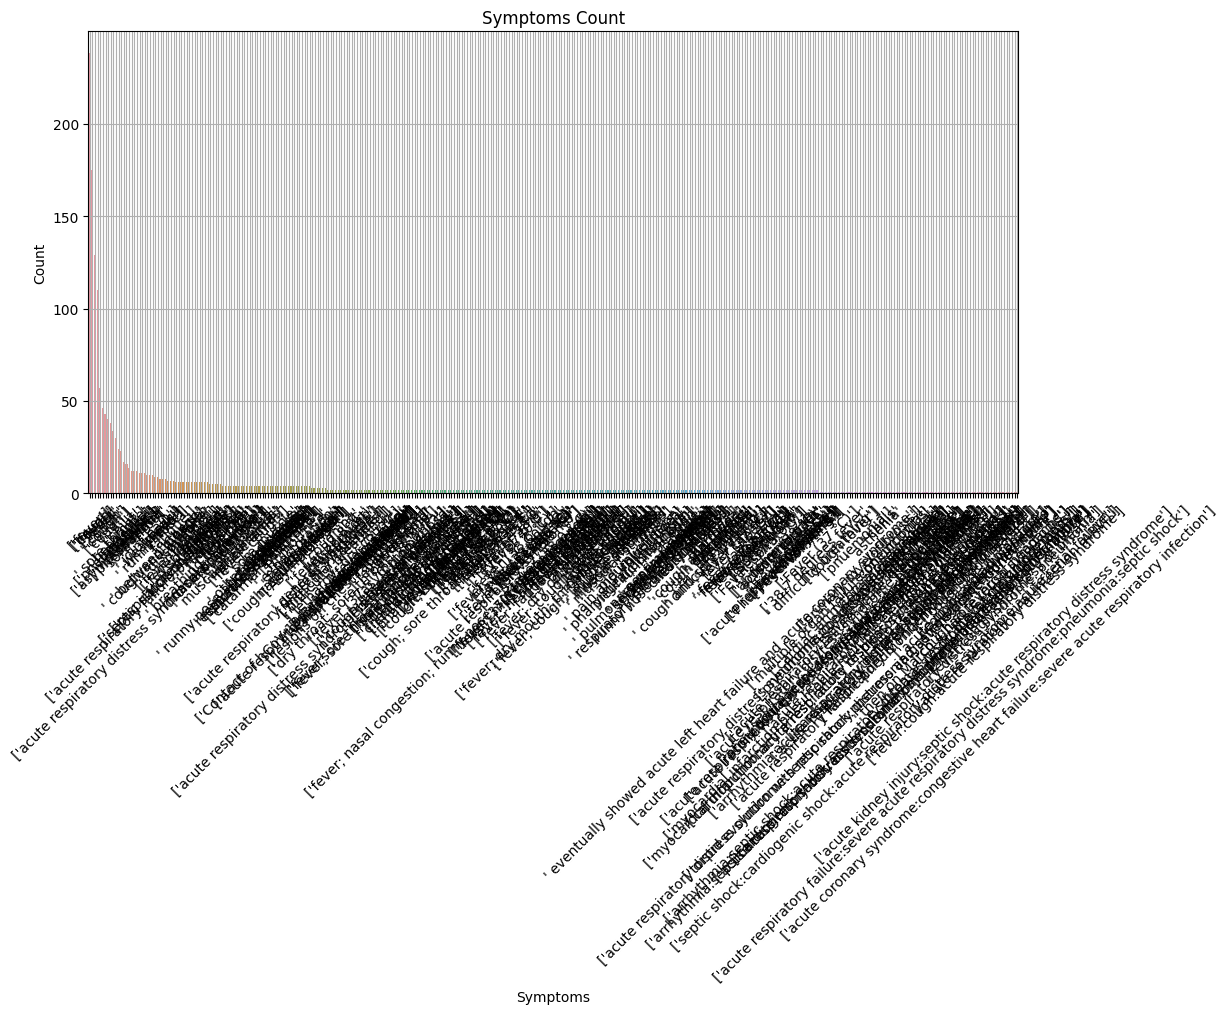

In [36]:
# Symptoms Count

symptoms_expanded = df['symptoms'].str.get_dummies(sep=', ')
symptoms_count = symptoms_expanded.sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=symptoms_count.index, y=symptoms_count.values)
plt.title('Symptoms Count')
plt.xlabel('Symptoms')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid()
plt.show()

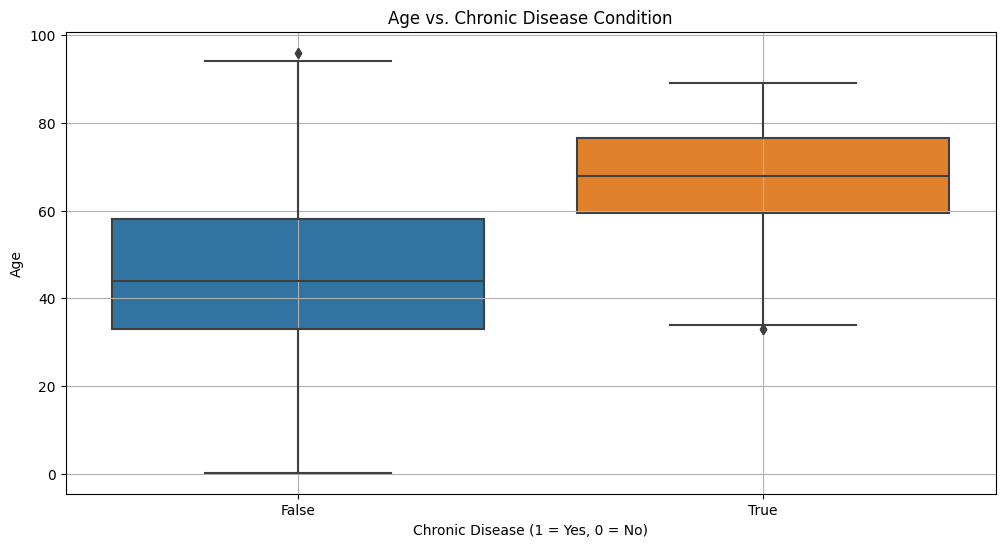

In [37]:
# Age vs. Chronic Disease

plt.figure(figsize=(12, 6))
sns.boxplot(x='chronic_disease_binary', y='age', data=df)
plt.title('Age vs. Chronic Disease Condition')
plt.xlabel('Chronic Disease (1 = Yes, 0 = No)')
plt.ylabel('Age')
plt.grid()
plt.show()

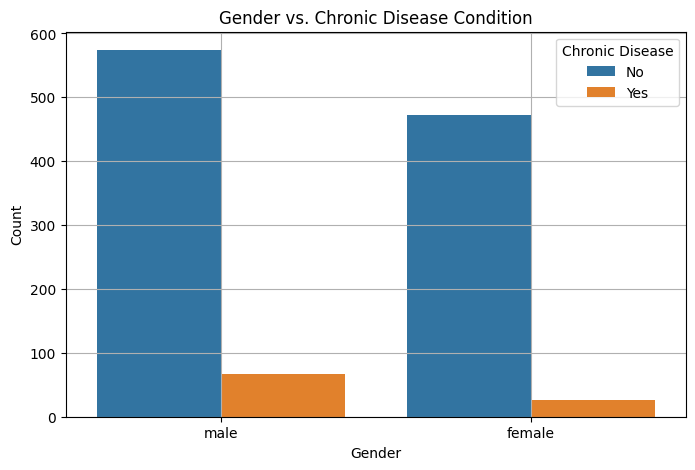

In [38]:
# Gender vs. Chronic Disease Condition

plt.figure(figsize=(8, 5))
sns.countplot(x='sex', hue='chronic_disease_binary', data=df)
plt.title('Gender vs. Chronic Disease Condition')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Chronic Disease', loc='upper right', labels=['No', 'Yes'])
plt.grid()
plt.show()

In [21]:
# Splitting comma and convert to list
df['symptoms'] = df['symptoms'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

In [22]:
# MultiLabelBinarizer to one-hot encode the symptoms
symptom_dummies = mlb.fit_transform(df['symptoms'])

In [23]:
# Create Dataframe with one-hot encoded and create transaction structure
symptom_df = pd.DataFrame(symptom_dummies, columns=mlb.classes_)

transaction_data = symptom_df.groupby(df.index).sum()

In [39]:
frequent_itemsets = apriori(transaction_data, min_support=0.05, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7)

c:\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [40]:
significant_rules = rules[(rules['lift'] > 1) & (rules['confidence'] > 0.5)]

In [41]:
print("Significant Rules:")
for index, row in significant_rules.iterrows():
    print(f"Rule: {row['antecedents']} -> {row['consequents']}, "
            f"Support: {row['support']:.4f}, "
            f"Confidence: {row['confidence']:.4f}, "
            f"Lift: {row['lift']:.4f}")

Significant Rules:
Rule: frozenset({' fever'}) -> frozenset({'cough'}), Support: 0.1184, Confidence: 0.7258, Lift: 3.8485


In [27]:
print("Frequent Itemsets:")
print(frequent_itemsets)
print("\nAssociation Rules:")
print(rules)

Frequent Itemsets:
    support         itemsets
0  0.078070         ( cough)
1  0.163158         ( fever)
2  0.188596          (cough)
3  0.305263          (fever)
4  0.118421  (cough,  fever)

Association Rules:
  antecedents consequents  antecedent support  consequent support   support  \
0    ( fever)     (cough)            0.163158            0.188596  0.118421   

   confidence      lift  leverage  conviction  zhangs_metric  
0    0.725806  3.848462   0.08765    2.959236       0.884463  
